In [1]:
from qiskit import QuantumCircuit,Aer,IBMQ,transpile, assemble,BasicAer,execute
%matplotlib inline
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

Input maximum 4 digit secret number: 010


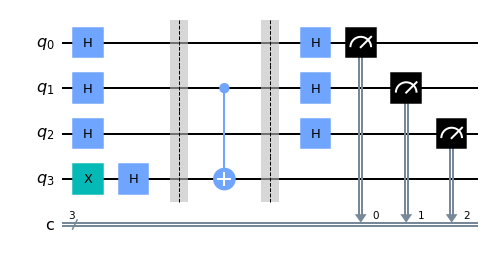

{'010': 1024}


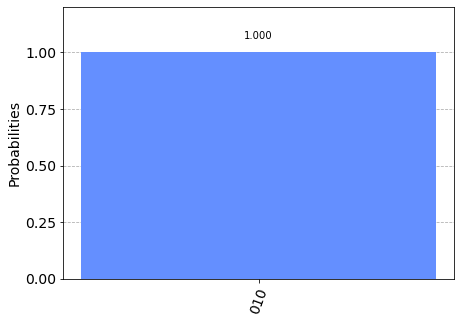

In [2]:
#secret number
try:
    secretnumber = int(input("Input maximum 4 digit secret number: "), 2)
    secretnumber = [int(i) for i in bin(secretnumber)[2:].zfill(3)]
    secretnumber = secretnumber[::-1]
except ValueError:
    print("Please input only binary value: ")

#1 ancilla
n = len(secretnumber)
qc=QuantumCircuit(n+1,n)
qc.x(n)
for i in range (n+1):
    qc.h(i)
qc.barrier()
for i in range (n):
    if secretnumber[i] == 1:
        qc.cx(i,n)
qc.barrier()
for i in range (n):
    qc.h(i)
# Measurement
for i in range(n):
    qc.measure(i, i)
display(qc.draw('mpl'))

#simulator
simulator = Aer.get_backend('qasm_simulator')
simulator_result = execute(qc, backend = simulator, shots = 1024).result()
simulator_counts = simulator_result.get_counts()
print(simulator_counts)
plot_histogram(simulator_counts)


C:\Users\prath\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


{'000': 49, '001': 5, '010': 877, '011': 33, '100': 24, '101': 3, '110': 29, '111': 4}


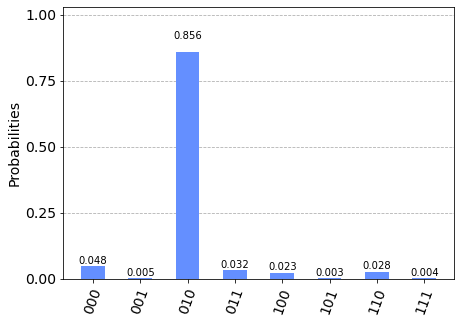

In [3]:
#real device
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q') 
#provider.backends()
#device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
#                                   x.configuration().n_qubits >= 2 and
 #                                  not x.configuration().simulator and x.status().operational==True))
device = provider.get_backend("ibmq_santiago")
#print("least busy backend: ", device)
#transpiled_qc = transpile(qc, backend = device)
#qobj = assemble(transpiled_qc, shots=1024)
#job = device.run(qobj)
#print(job.job_id())
#job_monitor(job, interval=2)
job = device.retrieve_job('608aab94e639d091d3da7424')
real_result = job.result()
real_counts = real_result.get_counts()
print(real_counts)
plot_histogram(real_counts)

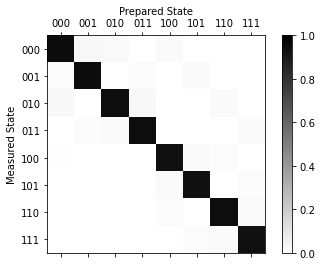

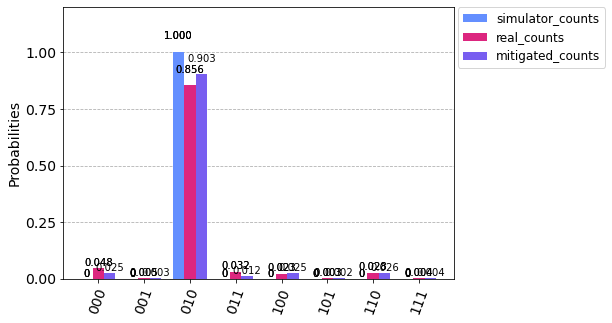

In [4]:
#from qiskit.quantum_info import Statevector, partial_trace
#import qiskit.quantum_info as qi
qct = QuantumCircuit(n,n)
cal_circuits, state_labels = complete_meas_cal(qr = qct.qregs[0], circlabel = 'measerrormitigationcal')
#cal_job = execute(cal_circuits, backend = device, shots=1024, optimization_level = 0)
cal_job = device.retrieve_job('608abcbee639d0c45dda74d0')
#print(cal_job.job_id())
#job_monitor(cal_job)
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(real_result)
mitigated_counts = mitigated_result.get_counts(qc)
plot_histogram([simulator_counts,real_counts, mitigated_counts], legend =['simulator_counts','real_counts','mitigated_counts'])